# NLP Kaggle Challenge: Match queries to similar patents

## Problem Description
Determining the semantic similarity between phrases is critically important during the patent search and examination process to determine if an invention has been described before. For example, if one invention claims "television set" and a prior publication describes "TV set", a model would ideally recognize these are the same and assist a patent attorney or examiner in retrieving relevant documents. This extends beyond paraphrase identification; if one invention claims a "strong material" and another uses "steel", that may also be a match. What counts as a "strong material" varies per domain (it may be steel in one domain and ripstop fabric in another, but you wouldn't want your parachute made of steel). The data includs the Cooperative Patent Classification as the technical domain context as an additional feature to help disambiguate these situations.

## Data Source
https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview

## Approach
I use a simple training of word embeddings and an embedding of the context. I expect this approach to be a strong baseline, but not a winner.

In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
# only needed for kaggle
! pip install openai


In [3]:
import random

def set_seed(seed=42):
    random.seed(seed)               # Python
    np.random.seed(seed)            # Numpy
    torch.manual_seed(seed)         # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)       # PyTorch CUDA
        torch.cuda.manual_seed_all(seed)   # PyTorch all GPUs
        torch.backends.cudnn.deterministic = True  # CUDNN
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Read data


In [4]:
from pathlib import Path

is_local= not Path("/kaggle").exists()
if is_local:
    df = pd.read_csv("~/Downloads/us-patent-phrase-to-phrase-matching/train.csv")
else:
    df = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")

df.head(),len(df)

(                 id     anchor                  target context  score
 0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
 1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
 2  36d72442aefd8232  abatement         active catalyst     A47   0.25
 3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
 4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00,
 36473)

## Preprocess: Get embeddings
Here you can use any embedding model to embed your text

In [5]:
from openai import Embedding
from typing import List

from tenacity import retry, stop_after_attempt, wait_random_exponential

# copied from openai since they have bigger dependencies in this file that I dont need 
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embeddings(
    list_of_text: List[str], engine="text-similarity-babbage-001", **kwargs
) -> List[List[float]]:
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."

    # replace newlines, which can negatively affect performance.
    list_of_text = [text.replace("\n", " ") for text in list_of_text]

    data = Embedding.create(input=list_of_text, engine=engine, **kwargs).data
    return [d["embedding"] for d in data]



In [6]:
import pickle
import os
from pathlib import Path

import openai
from tqdm.notebook import tqdm
import dotenv
dotenv.load_dotenv()

def add_embeddings(df,cache_file_prefix=""):
    max_batch_size=2048

    for col in ["anchor","target"]:
        cache = f'data/{cache_file_prefix}{col}.pickle' if is_local else  f'{cache_file_prefix}{col}.pickle'
        if Path(cache).exists():
            embeddings = pickle.load(open(cache,"rb"))
        else:
            # sign up with openai and generate a key. creating the embeddings costs 5 cents in August 2023
            # put your openai key in the a .env file in your repo root 
            # could be improved by adding a check if an embedding was already calculated but since it is so cheap, I don't bother for now
            if is_local:
                openai.api_key = os.environ["OPEN_AI_KEY"]
            else:
                from kaggle_secrets import UserSecretsClient
                user_secrets = UserSecretsClient()
                openai.api_key = user_secrets.get_secret("OPEN_AI_KEY")
            embeddings= []
            for i in tqdm(range(0,len(df),max_batch_size),total=len(df)//max_batch_size):
                texts= df[col].iloc[i:i+max_batch_size]
                embeddings.extend(get_embeddings(texts,engine="text-embedding-ada-002"))

            with open(cache, 'wb') as f:
                pickle.dump(embeddings, f)
        df[col+"_embeddings"]=embeddings
    return df

df=add_embeddings(df)

In [7]:
words = df.context.unique()
df["cat"] = df.context.str[0]
categories = df["cat"].unique()

word_to_ix= dict(zip(words, range(len(words))))
cat_to_ix= dict(zip(categories, range(len(categories))))

df["context_id"] = df.apply(lambda x:word_to_ix[x["context"]],axis=1)
df["cat_id"] = df.apply(lambda x:cat_to_ix[x["cat"]],axis=1)

In [8]:
eval_df= df.sample(3000, random_state=1).reset_index()
df =df.iloc[~df.index.isin(eval_df.index)].reset_index()
len(df),len(eval_df)

(33473, 3000)

## Baseline: Embedding cosine similarity


In [9]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [10]:
df["cosine_sim"]=df.apply(lambda x: cosine_similarity(x["anchor_embeddings"],x["target_embeddings"]),axis=1 )
eval_df["cosine_sim"]=eval_df.apply(lambda x: cosine_similarity(x["anchor_embeddings"],x["target_embeddings"]),axis=1 )

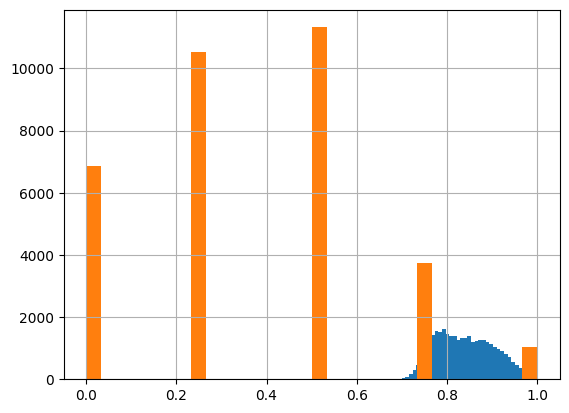

In [11]:
## compare target and actual
df.cosine_sim.hist(bins=40)
df.score.hist(bins=30);

# we see cosine clumps around 0.8, it is already interesting that most combinations have a somewhat high cosine similarity

### Visualize performance of cosine similarity with plain vanilla openai embeddings

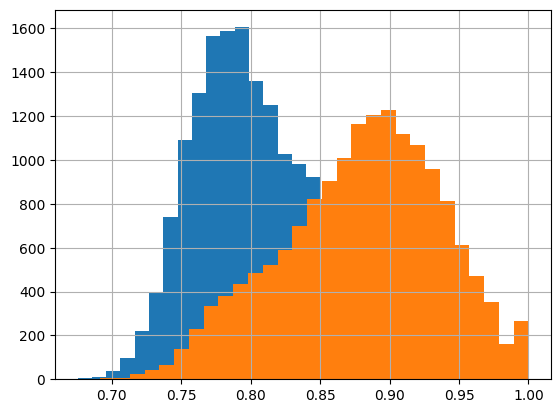

In [12]:
df.groupby(df.score>=0.5).cosine_sim.hist(bins=30);
# we see that the cosine similartiy is higher for higher scores, but it is not splitting similar and dissimilar well
# -> we confirm the problem observed in the tweet. Out of the box embeddings from openai will not serve us well
# when using cosine similarity

In [13]:
def mean_abs_error():
    return (df.cosine_sim-df.score).abs().mean()

mean_abs_error().round(2) # average error 0.5

0.48

In [14]:
from scipy import stats

stats.pearsonr(df.cosine_sim, df.score) 
# pearson score is used as an evaluation metric for this challenge

PearsonRResult(statistic=0.5901750160313239, pvalue=0.0)

## Train embeddings using plain pytorch

In [15]:
e1 = np.stack(np.array(df["anchor_embeddings"].values))
e1 = torch.from_numpy(e1).float()
e1.shape

torch.Size([33473, 1536])

In [16]:
e1 = torch.tensor(df.anchor_embeddings,dtype=torch.float32)
e2 = torch.tensor(df.target_embeddings,dtype=torch.float32)
context = torch.tensor(df.context_id,dtype=torch.int32)
target= torch.tensor(df.score,dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(e1, e2, context, target)

In [17]:
def model(embedding_1, embedding_2, context, context_embedding, matrix, dropout_perc=0):
    e1 = torch.nn.functional.dropout(embedding_1,dropout_perc)
    e2 = torch.nn.functional.dropout(embedding_2,dropout_perc)
    modified_embedding_1 = e1@ matrix  # @ is matrix multiplication

    # the modified embedding is multiplied with the specific context of the query. E.g. a "bird" in the context of nature is a bird, in the context of 
    # crime it could be a lookout post
    #modified_embedding_1 = modified_embedding_1 * context_embedding(context)

    modified_embedding_2 = e2@ matrix  
    # modified_embedding_2 = modified_embedding_2 * context_embedding(context)

    # adding one non-linearity to the model improves it a lot. the sample notebook only adds a linear transformation
    modified_embedding_1= torch.nn.functional.relu(modified_embedding_1)
    modified_embedding_2= torch.nn.functional.relu(modified_embedding_2)
    similarity = torch.nn.functional.cosine_similarity(
        modified_embedding_1, modified_embedding_2
    )
    return similarity

# define loss function to minimize
def mean_absolute_error(predictions, targets):
    difference = (predictions - targets).abs()
    return torch.mean(difference)

def pearson(predictions, targets):
    p= stats.pearsonr(predictions.detach(), targets.detach()).statistic
    return p

In [18]:
# before we start training, check with a sample batch
embedding_shape=1536
embedding_shape_modded = 1536
matrix = torch.randn(embedding_shape,embedding_shape_modded,requires_grad=True)
context_embedding = torch.nn.Embedding(num_embeddings=len(words),embedding_dim=embedding_shape_modded)

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2000, shuffle=False
    )
anchor_emeddings,target_embeddings,context, target_sim_score = next(iter(train_loader))
sims = model(anchor_emeddings,target_embeddings,context, context_embedding, matrix,dropout_perc=0)
loss = mean_absolute_error(predictions=sims, targets=target_sim_score)
p = pearson(target_sim_score,sims)
print(loss.item(),p)

0.49035319685935974 0.6184839653894958


In [19]:
e1_val = torch.tensor(eval_df.anchor_embeddings)
e2_val = torch.tensor(eval_df.target_embeddings)
context_val = torch.tensor(eval_df.context_id)
target_val= torch.tensor(eval_df.score)

def calc_evaluation_error(dropout_perc):
    sims = model(e1_val,e2_val,context_val,context_embedding,matrix,dropout_perc=dropout_perc)
    loss = mean_absolute_error(predictions=sims, targets=target_val)
    pearson= stats.pearsonr(sims.detach(), eval_df.score).statistic
    return loss, sims,pearson

In [20]:
#random init of the modification matrix
set_seed(1)

embedding_shape=1536
embedding_shape_modded = 1536

matrix = torch.randn(embedding_shape,embedding_shape_modded).requires_grad_()
#context_embedding = torch.nn.Embedding(num_embeddings=len(words),embedding_dim=embedding_shape_modded)

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=512*2, shuffle=True
    )

optim = torch.optim.Adam(lr=0.01, params=[matrix])#,context_embedding.weight])

def train(num_epochs,dropout_perc):
    for e in range(num_epochs):
        for i,(e1_batch,e2_batch,context, actual_similarity) in enumerate(train_loader):
            sims = model(e1_batch,e2_batch,context,context_embedding, matrix,dropout_perc=dropout_perc)
            loss = mean_absolute_error(predictions=sims, targets=actual_similarity)
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i%10==0:
                val_loss,_,pearson = calc_evaluation_error(dropout_perc)
                msg= f"{e} {i} training_loss {round(loss.item(),3)}, valdation loss {round(val_loss.item(),3)}, pearson {pearson.round(3)}"
                if dropout_perc!=0:
                    val_loss_0,_,pearson_val = calc_evaluation_error(dropout_perc=0)
                    msg= f"{e} {i} training_loss {round(loss.item(),3)}, valdation loss {round(val_loss.item(),3)}, {round(val_loss_0.item(),3)}, "\
                         f"pearson {pearson.round(3)}, {pearson_val.round(3)}"

                print(msg)        


In [21]:
train(50,dropout_perc=0.0)

0 0 training_loss 0.505, valdation loss 0.471, pearson 0.581
0 10 training_loss 0.198, valdation loss 0.183, pearson 0.591
0 20 training_loss 0.167, valdation loss 0.16, pearson 0.631
0 30 training_loss 0.157, valdation loss 0.152, pearson 0.659
1 0 training_loss 0.149, valdation loss 0.151, pearson 0.668
1 10 training_loss 0.149, valdation loss 0.146, pearson 0.693
1 20 training_loss 0.146, valdation loss 0.139, pearson 0.716
1 30 training_loss 0.142, valdation loss 0.134, pearson 0.734
2 0 training_loss 0.132, valdation loss 0.133, pearson 0.738
2 10 training_loss 0.13, valdation loss 0.127, pearson 0.758
2 20 training_loss 0.131, valdation loss 0.125, pearson 0.768
2 30 training_loss 0.13, valdation loss 0.122, pearson 0.778
3 0 training_loss 0.115, valdation loss 0.121, pearson 0.783
3 10 training_loss 0.114, valdation loss 0.118, pearson 0.793
3 20 training_loss 0.123, valdation loss 0.115, pearson 0.798
3 30 training_loss 0.117, valdation loss 0.113, pearson 0.808
4 0 training_lo

In [22]:
val_loss_0,val_sims,pearson_val, = calc_evaluation_error(dropout_perc=0)
val_loss_0.item(),pearson_val

(0.04754971501760989, 0.9458010654712562)

## Visalize results



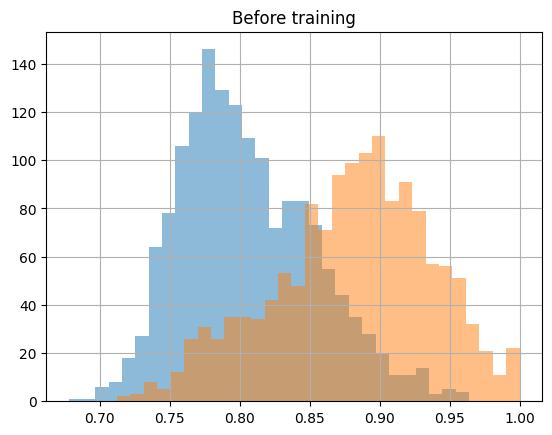

In [23]:
import matplotlib.pyplot as plt

eval_df.groupby(eval_df.score>=0.5).cosine_sim.hist(bins=30,alpha=0.5);
plt.title("Before training");


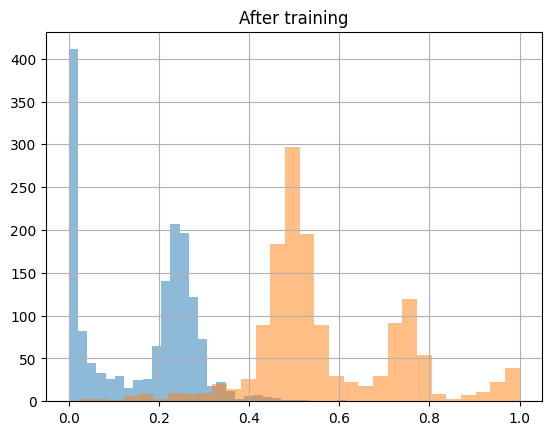

In [24]:
plt.title("After training");

sims=model(e1_val,e2_val, context_val, context_embedding, matrix)
eval_df["cosine_improved"]=sims.detach()
eval_df.groupby(eval_df.score>=0.5).cosine_improved.hist(bins=30,alpha=0.5);

# expected pattern, close to real scores (0.25 steps)

## Submission

In [25]:
if is_local:
    test_df = pd.read_csv("~/Downloads/us-patent-phrase-to-phrase-matching/test.csv")
else:
    test_df = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
test_df.head()


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [26]:
len(test_df)
# weird,only 36 entried, not ideal

36

In [27]:
# add features
test_df=add_embeddings(test_df,cache_file_prefix="eval_")
test_df["cat"] = test_df.context.str[0]
test_df["context_id"] = test_df.apply(lambda x:word_to_ix[x["context"]],axis=1)
test_df["cat_id"] = test_df.apply(lambda x:cat_to_ix[x["cat"]],axis=1)

In [40]:
test_df["cosine_sim"]=test_df.apply(lambda x: cosine_similarity(x["anchor_embeddings"],x["target_embeddings"]),axis=1 )

In [51]:
e1 = torch.tensor(test_df.anchor_embeddings,dtype=torch.float32)
e2 = torch.tensor(test_df.target_embeddings,dtype=torch.float32)
contexts= torch.tensor(test_df.context_id, dtype=torch.int)
cats= torch.tensor(test_df.cat_id, dtype=torch.int)

sims = model(e1,e1,contexts, context_embedding, matrix)
test_df["score"]=sims.detach()

In [52]:
test_df["score"].value_counts()

score
1.0    15
1.0     8
1.0     7
1.0     5
1.0     1
Name: count, dtype: int64

In [53]:
test_df["score"]

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
Name: score, dtype: float32

In [55]:
test_df[["id","score"]].to_csv("submission.csv",index=False)